# Satellite Image Analysis with Earth Engine and Python Open Source Packages

This exercise introduces Google Earth Engine and raster satellite image analysis and visualization. Working with data from the Sentinel-2 satellite system:
* Assemble images around a specific location and within a specified time period
 * Query metadata information about the images
* View an image statically and with an interactive map
* Calculate a 'spectral indice'
* Calculate change between two images
* Classify an image into statistical clusters
* Create a time series dataset from single location from the images
 * Visualize the time series with an interactive map 

The exercise can be run without any knowledge of coding, but for some background, you might want to run through the following coloboratory notebooks:

1. Earth Engine Python API Colab Setup
https://colab.research.google.com/github/google/earthengine-api/blob/master/python/examples/ipynb/ee-api-colab-setup.ipynb

2. Google Earth Engine with Python - Developer's Guide
https://colab.research.google.com/github/csaybar/EEwPython/blob/dev/1_Introduction.ipynb#scrollTo=5AkUqloUQpXv



## Set up the analysis environment

The basic steps to get things set up, using 'python' scripting jargon, are:

1.   Install packages
2.   Import modules
3. 'Authenticate' earth engine
4. Define functions

Colaboratory comes with a variety of standard scientific computing 'libraries', and many others can be installed fairly easily.  This exercise will use the 'earth engine api', the 'geemap' library for visualizing earth engine data, and a variety of libraries to plot results.

In [1]:
# install dependencies into virtual machine
!pip install geemap
#!pip install ee
#!pip install earthengine-api
!pip install geopandas
#!pip install altair


     |████████████████████████████████| 389kB 11.9MB/s 
     |████████████████████████████████| 225kB 17.3MB/s 
     |████████████████████████████████| 102kB 7.0MB/s 
     |████████████████████████████████| 1.9MB 25.0MB/s 
     |████████████████████████████████| 983kB 44.6MB/s 
     |████████████████████████████████| 1.1MB 49.6MB/s 
     |████████████████████████████████| 5.1MB 45.6MB/s 
     |████████████████████████████████| 81kB 7.3MB/s 
     |████████████████████████████████| 102kB 9.0MB/s 
     |████████████████████████████████| 71kB 5.9MB/s 
     |████████████████████████████████| 204kB 35.5MB/s 
     |████████████████████████████████| 112kB 50.8MB/s 
     |████████████████████████████████| 552kB 43.1MB/s 
     |████████████████████████████████| 122kB 50.7MB/s 
  Created wheel for ipynb-py-convert: filename=ipynb_py_convert-0.4.6-cp36-none-any.whl size=4625 sha256=f4bfc533513dda588ca87a9fd8da2cd01b426f15f3d435c5acd4413125904870
  Stored in directory: /root/.cache/pip/wheels/80/dc

     |████████████████████████████████| 972kB 12.4MB/s 
     |████████████████████████████████| 14.8MB 320kB/s 
     |████████████████████████████████| 6.5MB 44.4MB/s 


- #### *You may have now have to `RESTART RUNTIME` (with a button in the output above) to properly import the modules in the next step*

### Import modules

Plotting, visualization, and data analysis tools

In [2]:
# earth engine and statistical analysis
from IPython.display import Image
import ee, datetime
import pandas as pd
from pylab import *
import seaborn as sns

# file management
import os
import glob

# geospatial and plotting modules
#import geopandas as gpd
import geemap.eefolium as geemap

import folium
import matplotlib.pyplot as plt
%matplotlib inline

import altair as alt


### Authenticate earth engine

Since earth engine requires a login, to use it with colaboratory requires 'authenticating' an analysis session. That is, giving permission via a google account. Rinning the cell below will provide a link to a google authentication website, which will ask your permission and then provide a verification code to paste into a box - then hit enter to finish the process.

In [3]:
# Trigger the authentication flow.
ee.Authenticate()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=OYVoq9lLTqU_KM3piae5BXfLJ3CAVf8YykMiJf1OcBk&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g7ThZ3Q83W_iNEx3Sulf1O9KDxcoL5C6HoXsdTqLAdxLBdyQoBia04

Successfully saved authorization token.


Once it has `Successfully saved authorization token` the session can be 'initialized'

In [4]:
# start up the session
ee.Initialize()

## Define Functions

Functions do something with information. Here are functions to *mask* out clouds and cloud shadows, and to calculate a variety of *spectral indices* from the image data.   Sentinel-2 and Landsat 8 satellite image data are used.

- Landsat 8 data is called with `ee.ImageCollection("LANDSAT/LC08/C01/T1_SR")` in the script and described here: https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C01_T1_SR

- The functions for masking are adapted from here: https://code.earthengine.google.com/?scriptPath=Examples:Datasets/LANDSAT_LC08_C01_T1_SR

- Sentinel-2 data is called with `ee.ImageCollection("COPERNICUS/S2_SR")` and described here: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2

**Sentinel-2** image bands used in the functions are:

- Band 4 = red
- Band 8 = NIR
- at 10m pixel resolution

**Landsat 8** bands used are:
- Band 4 = red
- Band 5 = NIR
- at 30m pixel resolution

The exercise uses Sentinel-2 data, and can be adapted to work with Landsat 8.

### Cloudmask functions

These will mask clouds from the image collections to help improve analysis results of the time series data.

In [105]:
#function to use QA band to filter clouds
#Landsat 8 sr data
def maskL8sr(image):
  #Bits 3 and 5 are cloud shadow and cloud, respectively.
  cloudShadowBitMask = (1 << 3)
  cloudsBitMask = (1 << 5)
  # Get the pixel QA band.
  qa = image.select('pixel_qa')
  # Both flags should be set to zero, indicating clear conditions.
  mask = qa.bitwiseAnd(cloudShadowBitMask).bitwiseAnd(cloudsBitMask)
  # mask = qa.bitwiseAnd((cloudShadowBitMask).eq(0)).bitwiseAnd((cloudsBitMask).eq(0))  # NOTE: this was not working for landsat8 data and was raising an error
  return image.updateMask(mask)

In [6]:
#function to use QA band to filter clouds
#Sentinel 2 data
def maskS2clouds(image):
  qa = image.select('QA60')

  #Bits 10 and 11 are clouds and cirrus, respectively.
  cloudBitMask = 1 << 10
  cirrusBitMask = 1 << 11

  #Both flags should be set to zero, indicating clear conditions.
  mask = qa.bitwiseAnd(cloudBitMask).eq(0)
  mask2 = qa.bitwiseAnd(cirrusBitMask).eq(0)
  mask3 = qa.bitwiseAnd(cloudBitMask).eq(0).bitwiseAnd(cirrusBitMask).eq(0)
  #cloud_img = image.updateMask(mask)
  #cir_img = cloud_img.updateMask(mask2)

  return image.updateMask(mask).updateMask(mask2)
  #return image.updateMask(mask)

### Spectral indices and transformations

Spectral indices are designed to combine different wavelengths of energy in order to highlight some materials or features of interest.

Code for the Landsat 8 indices was adapted from *renelikestacos* on github. There are quite a few here, and many more have been created.

This exercise uses the *NDVI (Normalized Difference Vegetation Index)* as an example. NDVI is [described here](https://earthobservatory.nasa.gov/features/MeasuringVegetation/measuring_vegetation_2.php) in the context of the MODIS sensor system - this exercise uses Sentinel-2 imagery which has 10 meter size pixels.

Other indices are described here:
- [Landsat 8 Spectral Indices](https://www.usgs.gov/core-science-systems/nli/landsat/landsat-surface-reflectance-derived-spectral-indices?qt-science_support_page_related_con=0#qt-science_support_page_related_con)
- [Sentinel-2 indices](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/indexdb/) On first look-over I thought there was one for "Macaroni" but I misread the table.

In [7]:
# Landsat 8 indices
def NDVI(image):
    return image.normalizedDifference(['B5', 'B4'])

def SAM(image):
    band1 = image.select("B1")
    bandn = image.select("B2","B3","B4","B5","B6","B7","B8","B9");
    maxObjSize = 256;
    b = band1.divide(bandn);
    spectralAngleMap = b.atan();
    spectralAngleMap_sin = spectralAngleMap.sin();
    spectralAngleMap_cos = spectralAngleMap.cos();
    sum_cos = spectralAngleMap_cos.reduce(ee.call("Reducer.sum"));
    sum_sin = spectralAngleMap_sin.reduce(ee.call("Reducer.sum"));
    return ee.Image.cat(sum_sin, sum_cos, spectralAngleMap_sin, spectralAngleMap_cos);

#Enhanced Vegetation Index
def EVI(image):
    # L(Canopy background)
    # C1,C2(Coefficients of aerosol resistance term)
    # GainFactor(Gain or scaling factor)
    gain_factor = ee.Image(2.5);
    coefficient_1 = ee.Image(6);
    coefficient_2 = ee.Image(7.5);
    l = ee.Image(1);
    nir = image.select("B5");
    red = image.select("B4");
    blue = image.select("B2");
    evi = image.expression(
        "Gain_Factor*((NIR-RED)/(NIR+C1*RED-C2*BLUE+L))",
        {
            "Gain_Factor":gain_factor,
            "NIR":nir,
            "RED":red,
            "C1":coefficient_1,
            "C2":coefficient_2,
            "BLUE":blue,
            "L":l
        }
    )
    return evi

#Atmospherically Resistant Vegetation Index
def ARVI(image):
    red = image.select("B4")
    blue = image.select("B2")
    nir = image.select("B5")
    red_square = red.multiply(red)
    arvi = image.expression(
        "NIR - (REDsq - BLUE)/(NIR+(REDsq-BLUE))",{
            "NIR": nir,
            "REDsq": red_square,
            "BLUE": blue
        }
    )
    return arvi

#Leaf Area Index
def LAI(image):
    nir = image.select("B5")
    red = image.select("B4")
    coeff1 = ee.Image(0.0305);
    coeff2 = ee.Image(1.2640);
    lai = image.expression(
        "(((NIR/RED)*COEFF1)+COEFF2)",
        {
            "NIR":nir,
            "RED":red,
            "COEFF1":coeff1,
            "COEFF2":coeff2
        }
    )
    return lai

This exercise demonstrates the use of Sentinel-2 image data, so these indices need to be adapted to the different band names in the dataset.

In [8]:
# adapted to Sentinel-2

# NDVI for Sentinel-2 bands
def senNDVI(image):
    return image.normalizedDifference(['B8', 'B4'])

## Create target areas for analysis

A single point will be used to set the initial data search.  

Note that this is 'x, y' style (longitude, latitude)
 - Hagen Research Natural Area (up the South Fork of Gate Creek): [-122.418960, 44.163945]


In [11]:
# use the Gate Creek point
rnapoint = [-122.418960, 44.163945]

In [12]:
# Create earth engine point
point = {'type':'Point', 'coordinates':rnapoint}

## Create image collection

An 'image collection' is a group (or filtered group) of related imagery or other data.

- [ImageCollection Overview](https://samapriya.github.io/gee-py/projects/collection_overview/)

Images in earth engine are described here.

- [Image Overview](https://samapriya.github.io/gee-py/projects/imgoverview/)

Collections can be vast, so commonly they are filtered by a geographic area or time period.

### Set time period

This exercise uses data from early 2015 to the October 10, 2020. The Sentinel-2 image collection frequency increases over this time as a second sensor comes into use.

Landsat 8 dataset availability is from April 2013 onwards, so a longer time period could be analysed with this data.

In [9]:
# Set start and end date
startTime = datetime.datetime(2015, 3, 28)
# endTime = datetime.datetime.now()
endTime = datetime.datetime(2020, 11, 9)

### Load Landsat8 image collection




In [64]:
# Create Sentinel-2 image collection
# collection = ee.ImageCollection("COPERNICUS/S2").filterDate(startTime, endTime).filterBounds(point)

# Create Landsat 8 image collection
collection = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR").filterDate(startTime, endTime).filterBounds(point)

### Image Collection Information and Metadata

It is usually a good idea to examine the data in the collections created. 

In [14]:
# Get the number of images.
count = collection.size()
print('Count: ', str(count.getInfo())+'\n')

Count:  315



In [16]:
# Get the date range of images in the collection.
drange = collection.reduceColumns(ee.Reducer.minMax(), ["system:time_start"])
mindate = (ee.Date(drange.get('min')).getInfo())
maxdate = (ee.Date(drange.get('max')).getInfo())
print(f'Landsat8 Date range: {mindate} to {maxdate}')

Landsat8 Date range: {'type': 'Date', 'value': 1427568584510} to {'type': 'Date', 'value': 1603738606703}


Those dates look a little odd - they are a timestamp (in milliseconds) from Jan 1, 1970 - this is 'UNIX epoch time.' We can convert back to a more human-readable format this way:

In [17]:
# divide by 1000 to convert from milliseconds
datetime.datetime.fromtimestamp(0/1000)

datetime.datetime(1970, 1, 1, 0, 0)

So the date / time of the oldest image in this particular collection is:

In [18]:
datetime.datetime.fromtimestamp(1445454617457/1000)

datetime.datetime(2015, 10, 21, 19, 10, 17, 457000)

There are many other types of information about the images in the metadata.

In [19]:
#Get a list of all metadata properties.
properties = collection.propertyNames()
print('Metadata properties: '+str(properties.getInfo())) # ee.List of metadata properties

Metadata properties: ['system:visualization_0_min', 'type_name', 'visualization_1_bands', 'thumb', 'visualization_1_max', 'description', 'source_tags', 'visualization_1_name', 'system:id', 'visualization_0_max', 'title', 'system:visualization_2_max', 'product_tags', 'provider', 'visualization_1_min', 'system:visualization_2_name', 'visualization_0_min', 'system:version', 'system:visualization_1_bands', 'system:visualization_1_max', 'visualization_0_name', 'date_range', 'visualization_2_bands', 'visualization_2_name', 'period', 'system:visualization_2_min', 'system:visualization_0_bands', 'visualization_2_min', 'provider_url', 'sample', 'system:visualization_1_name', 'tags', 'system:visualization_0_max', 'visualization_2_max', 'system:visualization_2_bands', 'system:visualization_1_min', 'system:visualization_0_name', 'visualization_0_bands']


### Metadata for the first image in the collection

'Metadata' or standarized information about a dataset, is useful both for human-understanding of the usefulness (or not) of a particular dataset. More information about getting metatdata can be found at these links: 
- https://developers.google.com/earth-engine/ic_info
- https://samapriya.github.io/gee-py/projects/collection_meta/

In [20]:
# sort the collection by time of image acquisition
sorted = collection.sort("system:time_start");

# Get the first (oldest) image.
scene = sorted.first()

In [21]:
#properties of the image
properties = scene.propertyNames()
print('Metadata properties: '+str(properties.getInfo())) # ee.List of metadata properties

Metadata properties: ['IMAGE_QUALITY_TIRS', 'CLOUD_COVER', 'system:id', 'EARTH_SUN_DISTANCE', 'LANDSAT_ID', 'system:footprint', 'system:version', 'CLOUD_COVER_LAND', 'GEOMETRIC_RMSE_MODEL', 'SR_APP_VERSION', 'SATELLITE', 'SOLAR_AZIMUTH_ANGLE', 'IMAGE_QUALITY_OLI', 'WRS_PATH', 'system:time_start', 'SENSING_TIME', 'ESPA_VERSION', 'SOLAR_ZENITH_ANGLE', 'WRS_ROW', 'GEOMETRIC_RMSE_MODEL_Y', 'LEVEL1_PRODUCTION_DATE', 'GEOMETRIC_RMSE_MODEL_X', 'system:asset_size', 'PIXEL_QA_VERSION', 'system:index', 'system:bands', 'system:band_names']


In [22]:
#Get the 'tile' location identifier
target = 'MGRS_TILE'
meta = scene.get(target).getInfo()
print('{} = {}'.format(target, meta))

MGRS_TILE = None


In [23]:
#Get the data id
target = 'GRANULE_ID'
meta = scene.get(target).getInfo()
print('{} = {}'.format(target, meta))

GRANULE_ID = None


In [24]:
#Get estimated cloud cover
target = 'CLOUD_COVERAGE_ASSESSMENT'
meta = scene.get(target).getInfo()
print('{} = {}'.format(target, meta))

CLOUD_COVERAGE_ASSESSMENT = None


In [25]:
#Get the timestamp and convert it to a date.
date = ee.Date(scene.get('system:time_start')).getInfo()
# print(date['value'])
x=date['value']
print(datetime.datetime.fromtimestamp(x/1000))

2015-03-28 18:49:44.510000


In [26]:
oldest = collection.sort('system:time_start').limit(1)
scene = oldest.first()
#Get a specific metadata property.
target = 'system:time_start'
meta = scene.get(target).getInfo()
print('{} = {}'.format(target, meta))

#Get the timestamp and convert it to a date.
date = ee.Date(scene.get('system:time_start')).getInfo()
# print(date['value'])
x=date['value']
print(datetime.datetime.fromtimestamp(x/1000))

system:time_start = 1427568584510
2015-03-28 18:49:44.510000


# **Assignment: Geog 485**

What  does the “MGRS_TILE” metadata mean in the context of the Sentinel-2 image collection - how do we interpret the value ‘10TEP’? Describe how the Sentinel-2 tile system works.

Here is the code cell again...

In [27]:
#Get the 'tile' location identifier
target = 'MGRS_TILE'
meta = scene.get(target).getInfo()
print('{} = {}'.format(target, meta))

MGRS_TILE = None


# **Assignment: Geog 491**

What data type are the `mindate` and `maxdate` variables? How could the outputof the code below be made to print the following:
```
Landsat8 Date range: 1445454617457 to 1604430749547
```
instead of:
```
# Landsat8 Date range: {'type': 'Date', 'value': 1445454617457} to {'type': 'Date', 'value': 1604862746318}
```





In [28]:
# this is the code below, mentioned above
# Get the date range of images in the collection.
drange = collection.reduceColumns(ee.Reducer.minMax(), ["system:time_start"])
mindate = (ee.Date(drange.get('min')).getInfo()['value']) # datatype is dict so provide the relevant key
maxdate = (ee.Date(drange.get('max')).getInfo()['value']) # datatype is dict so provide the relevant key
print(f'Landsat8 Date range: {mindate} to {maxdate}')

Landsat8 Date range: 1427568584510 to 1603738606703


# **Assignment: Geog 491**

Write a function to convert a timestamp from a date, given a ee image.

Adapt the code below, so that given an image, the output will be the date/time in a more human readable format.

>The function could start something like this:

```
def ts_toDate(scene):
  # your function here
  ``` 
>
>and end up printing output such as:
>
`2015-10-21 19:10:17.457000`





In [29]:
def ts_toScene(scene):
    #Get the timestamp and convert it to a date.
    date = ee.Date(scene.get('system:time_start')).getInfo()
    # print(date['value'])
    x=date['value']
    print(datetime.datetime.fromtimestamp(x/1000))

ts_toScene(scene)

2015-03-28 18:49:44.510000


## View the most recent image

The data can be viewed as a static image or with an interactive map. First, the static image - these are handy because you can copy and paste them directly into another document


In [42]:
# Limit the collection to the 1 most recent images.
recent = collection.sort('system:time_start', False).limit(1)
# pull the image from the collection
image = recent.first()
print('Recent images: '+str(recent.getInfo())+'\n')

Recent images: {'type': 'ImageCollection', 'bands': [], 'id': 'LANDSAT/LC08/C01/T1_SR', 'version': 1605191934168228, 'properties': {'system:visualization_0_min': '0.0', 'type_name': 'ImageCollection', 'visualization_1_bands': 'B5,B4,B3', 'thumb': 'https://mw1.google.com/ges/dd/images/LANDSAT_SR_thumb.png', 'visualization_1_max': '30000.0', 'description': '<p>This dataset is the atmospherically corrected\nsurface reflectance from  the Landsat 8 OLI/TIRS sensors.\nThese images contain 5 visible and near-infrared (VNIR) bands and\n2 short-wave infrared (SWIR) bands processed to orthorectified surface\nreflectance, and two thermal infrared (TIR) bands processed to orthorectified\nbrightness temperature</p><p>These data have been atmospherically corrected using\n<a href="https://prd-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/atoms/files/LSDS-1368_L8_C1-LandSurfaceReflectanceCode-LASRC_ProductGuide-v3.pdf">LaSRC</a>\nand includes a cloud, shadow, water and snow mask produced

In [75]:
# set the visualization parameters for the output
visParams = {'bands': ['B4', 'B3', 'B2'], 'max': 3000, 'dimensions':1000 }

# create image thumbnail in earth engine and view
thumbnail = image.getThumbUrl(visParams)
Image(url=thumbnail)

It is a bit cloudy as of this run. The 'least cloudy' images - there are probably many, can be pulled from the collection using the Quality Assurance band

## Get the least cloudy image 

The metadata for the collection allows the sorting by estimated cloud cover - for now, limit it to the ten least cloudy images


In [93]:
sorted = collection.sort('CLOUD_COVERAGE_ASSESSMENT').limit(10)

# Get the first (least cloudy) image.
image = sorted.first();

In [94]:
# Get the number of images.
count = sorted.size()
print('Count: ', str(count.getInfo())+'\n')

# Get the date range of images in the collection.
drange = sorted.reduceColumns(ee.Reducer.minMax(), ["system:time_start"])
print('Landsat8 Date range: ', str(ee.Date(drange.get('min')).getInfo()), str(ee.Date(drange.get('max')).getInfo())+'\n')

Count:  10

Landsat8 Date range:  {'type': 'Date', 'value': 1427568584510} {'type': 'Date', 'value': 1440010200918}



In [95]:
#Get the timestamp and convert it to a date.
date = ee.Date(image.get('system:time_start')).getInfo()
# print(date['value'])
x=date['value']
print(datetime.datetime.fromtimestamp(x/1000))

2015-03-28 18:49:44.510000


An image from July 2, 2017. View this 'least cloudy' image.

In [96]:
visParams = {'bands': ['B4', 'B3', 'B2'], 'max': 3000, 'dimensions':1000}
thumbnail = image.getThumbUrl(visParams)
Image(url=thumbnail)

## Calculate and view NDVI

This image is much better.

The NDVI is calculated with a ratio of two wavelenths of reflected energy - 'red' and 'near-infrared'.

Higher NDVI values should correspond to larger amounts of green vegetation. To calculate this, run the Sentinel-2 NDVI function made earlier in the exercise on the existing image.

In [44]:
# run the landsat NDVI function
ndvi = NDVI(image)

In [45]:
# change visualization setting for the NDVI data
visParams = {'min':0, 'max': 1, 'dimensions':1000}
thumbnail = ndvi.getThumbUrl(visParams)
Image(url=thumbnail)

Brighter areas in the image should represent areas with higher amounts of growing green vegetation.

## View scene interactively

To examine whether NDVI is actually showing growing vegetation more closely, an interactive map is useful.  

The *folium* python library can be used to view this same data on an interactive map.  Multiple layers and other graphics can also be viewed, ans the visualization saved as an .html file.

First, lets get the parameters for visualization set up.

In [46]:
# visualization settings
rgbParams = {'bands': ['B4', 'B3', 'B2'], 'max': 3000, 'gamma': [1.4,1.2, 1.4]}
ndviParams = {'min':0, 'max': 1}

In [47]:
# flip the point coordinate to be lat, long (y, x) for folium
f = folium.Figure(width=800, height=600)
Map = geemap.Map(center=rnapoint[::-1], zoom= 12).add_to(f)
Map.addLayer(image, rgbParams, 'Natural Color Sentinel-2');
Map.addLayer(ndvi, ndviParams, 'NDVI')
Map.addLayerControl()
f

## Find the least cloudy recent image and examine

Now, to compare the above image (from 2017) with a more recent, relatively cloud free image.

In [48]:
# Limit the collection to the 10 most recent images.
recent = collection.sort('system:time_start', False).limit(10)

sorted = recent.sort('CLOUD_COVERAGE_ASSESSMENT')

# Get the first (least cloudy) image.
recentqa = sorted.first()

recentndvi = NDVI(recentqa) 

In [49]:
#Get the timestamp and convert it to a date.
date = ee.Date(recentqa.get('system:time_start')).getInfo()
# print(date['value'])
x=date['value']
print(datetime.datetime.fromtimestamp(x/1000))

2020-10-26 18:56:46.703000


### An image from October 9, 2020

In this run, it is Oct. 9th, 2020.

Lets look at this data, and add the point used to 'filter' the collection geographically as well.

In [50]:
# flip the point coordinate to be lat, long (y, x) for folium
f = folium.Figure(width=800, height=600)
Map = geemap.Map(center=rnapoint[::-1], zoom= 12).add_to(f)
Map.addLayer(image, rgbParams, 'Before Natural Color')
Map.addLayer(recentndvi, ndviParams, 'NDVI recently')
Map.addLayer(ndvi, ndviParams, 'NDVI before')
Map.addLayerControl()
folium.Marker(rnapoint[::-1], popup='<i>Research Natural Area</i>').add_to(Map)

f

### Use image math to compare the images

Compute a difference image of NDVI between the two dates.

Image math is relatively straightforward with earth engine (and it could also be calculated outside earth engine with the 'numpy' and related modules.

In [51]:
# create image expression
# the 'subtract() mathmatical operator could also be used
# dif = recentndvi.subtract(sndvi)
dif = image.expression('new-old', {'new': recentndvi, 'old': ndvi})
difParams = {'min':-1, 'max': 1, 'palette': ['red', 'grey', 'green']}

Examine the result - redder areas have less green vegation recently compared to 2017, while green areas have more.

In [52]:
# plot the difference image along with the other layers
f = folium.Figure(width=800, height=600)
# flip the point coordinate to be lat, long (y, x) for folium
Map = geemap.Map(center=rnapoint[::-1], zoom= 11).add_to(f)
Map.addLayer(image, rgbParams, 'Before Natural Color')
Map.addLayer(recentqa, rgbParams, 'Recent Natural Color')
Map.addLayer(recentndvi, ndviParams, 'NDVI recently')
Map.addLayer(ndvi, ndviParams, 'NDVI before')
Map.addLayer(dif, difParams, 'dif')
Map.addLayerControl()
folium.Marker(rnapoint[::-1], popup='<i>Research Natural Area</i>').add_to(Map)

f

# Assignment: Geog 485

## What explains the changes visible in the NDVI difference image?

Greener areas are estimated to have more growing green vegetation recently, while redder areas are estimated to have less. Think about the time difference between the images as well.

- seasonality,
- atmosphere,
- solar orientation,
- actual LULC change

There is likely more than one factor at play - don't forget to look at the images from the two dates in addition to the NDVI difference image for your answer - and to examine the entire image area using the zoom and pan tools.

## Time Series Analysis 

Since the collection has hundreds of images of this area since 2015, this data can be used to look at the variation of NDVI over a single point as a time series.


### Retrieve information over the collection time period

The point used to geographically limit the image collection can be used to gather information from a single area over the entire time period.  The code for this is described [here](https://developers.google.com/earth-engine/apidocs/ee-imagecollection-getregion).  

In [67]:
info = collection.getRegion(point,10).getInfo()

### mask clouds to create a filtered collection

We can use the cloud mask function created earlier to remove data that has been identified as cloudy in the collection, to compare with the data above.

This new result will be called `dataset`

In [106]:
# apply the cloud mask to the collection
maskeddata = collection.map(maskL8sr)

Get information about the filtered collection

In [107]:
# get the data for a specific area
info_filt = maskeddata.getRegion(point,10).getInfo()

### Compare the unfilitered and the filtered collection

Plot the data by turning it into a pandas dataframe and using the seaborn package to visualize it

## unfiltered

Text(0.5, 1.0, 'NDVI')

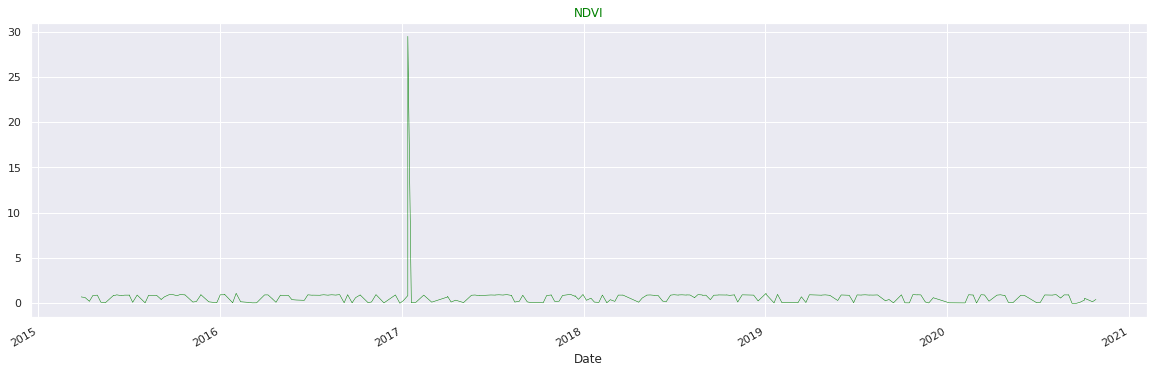

In [77]:
# plot the ndvi
data = info

# Reshape image collection 
header = data[0]
data = array(data[1:])

iTime = header.index('time')
time = [datetime.datetime.fromtimestamp(i/1000) for i in (data[0:,iTime].astype(int))]

# List of used image bands
#band_list = ['RED',u'NIR']
band_list = ['B4',u'B5'] # landsat collection doesnt have band 8

iBands = [header.index(b) for b in band_list]
yData = data[0:,iBands].astype(np.float)

# Calculate NDVI
red = yData[:,0]
nir = yData[:,1]
ndvi = (nir - red) / (nir + red)

# reshaoe NDVI into Pandas
df = pd.DataFrame(data=ndvi, index=list(range(len(ndvi))), columns=['NDVI'])
df = df.interpolate()
df['Date'] = pd.Series(time, index=df.index)
df = df.set_index(df.Date)
df.index = pd.to_datetime(df.index)
df['NDVI']=df['NDVI'].fillna(0)

sns.set(rc={'figure.figsize':(20, 6)})
df['NDVI'].plot(linewidth=0.5, color="green")
plt.title('NDVI', color='green')

Lots of spikiness - much of it related to cloudy pixels

### Plot the filtered data

Text(0.5, 1.0, 'NDVI')

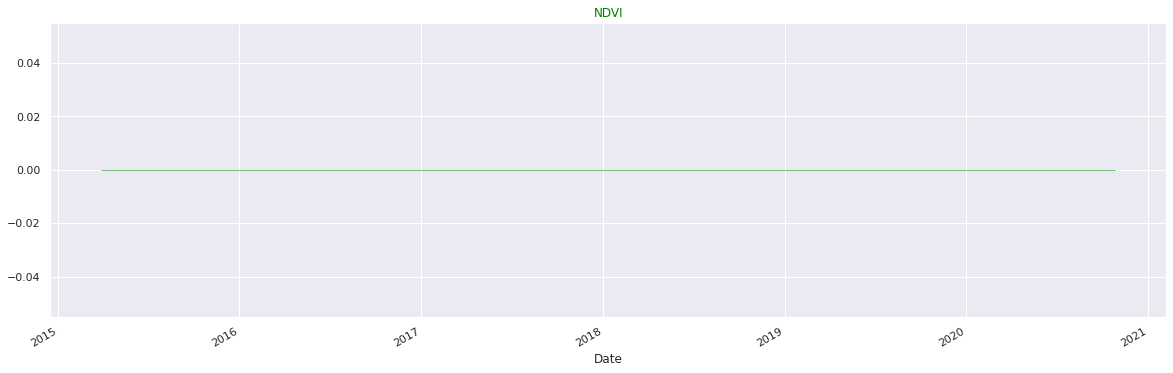

In [81]:
## plot the ndvi
data = info_filt

# Reshape image collection 
header = data[0]
data = array(data[1:])

iTime = header.index('time')
time = [datetime.datetime.fromtimestamp(i/1000) for i in (data[0:,iTime].astype(int))]

# List of used image bands
#band_list = ['RED',u'NIR']
band_list = ['B4',u'B5']  # landsat collection doesnt have band 8

iBands = [header.index(b) for b in band_list]
yData = data[0:,iBands].astype(np.float)

# Calculate NDVI
red = yData[:,0]
nir = yData[:,1]
ndvi = (nir - red) / (nir + red)
# reshaoe NDVI into Pandas
df = pd.DataFrame(data=ndvi, index=list(range(len(ndvi))), columns=['NDVI'])
df = df.interpolate()
df['Date'] = pd.Series(time, index=df.index)
df = df.set_index(df.Date)
df.index = pd.to_datetime(df.index)
df['NDVI']=df['NDVI'].fillna(0)

sns.set(rc={'figure.figsize':(20, 6)})
df['NDVI'].plot(linewidth=0.5, color="green")
plt.title('NDVI', color='green')

A little better, now examine the actual filtered data

In [79]:
df.head(5)

,NDVI,Date
Date,,
2015-03-28 18:49:44.510,0.0,2015-03-28 18:49:44.510
2015-04-13 18:49:39.180,0.0,2015-04-13 18:49:39.180
2015-04-29 18:49:31.410,0.0,2015-04-29 18:49:31.410
2015-05-15 18:49:16.660,0.0,2015-05-15 18:49:16.660
2015-05-31 18:49:22.730,0.0,2015-05-31 18:49:22.730


## Interactive mapping

### Make an interactive map with the chart data embedded

The information we just plotted can be placed onto the interactive map, using the 'Altair' module for plotting. 

Altair is designed to quickly make charts that can be displayed online

https://altair-viz.github.io/getting_started/overview.html

Using the "NDVI" and "Date" columns, plot the NDVI over time.


In [82]:
chart = alt.Chart(df).mark_line().encode(y='NDVI', x='Date')
chart

alt.Chart(...)

Fix the size a bit.

Chart Size: 
https://altair-viz.github.io/user_guide/customization.html#adjusting-chart-size

In [83]:
chart = alt.Chart(df).mark_line().encode(y='NDVI', x='Date').properties(width=700, height=200)

chart

alt.Chart(...)

This is still pretty spikey.  Much this is probably due to clouds, haze, smoke, or fog in the atmosphere - or snow on the ground.

### Embed the chart onto the folium map

This rendition of the data can be embedded on the map as a pop up for a point.


In [84]:
chart = alt.Chart(df).mark_line().encode(y='NDVI', x='Date').properties(width=500, height=150)
vis1 = chart.to_json()

f = folium.Figure(width=800, height=600)
# flip the point coordinate to be lat, long (y, x) for folium
Map = geemap.Map(center=rnapoint[::-1], zoom= 11).add_to(f)
#Map.addLayer(image, rgbParams, 'Before Natural Color')
Map.addLayer(recentqa, rgbParams, 'Recent Natural Color')
#Map.addLayer(recentndvi, ndviParams, 'NDVI recently')
#Map.addLayer(sndvi, ndviParams, 'NDVI before')
Map.addLayer(dif, difParams, 'dif')
Map.addLayerControl()
#folium.Marker(rnapoint[::-1], popup='<i>Research Natural Area</i>').add_to(Map)

# create a marker, with altair graphic as popup
circ_mkr = folium.CircleMarker(
    location=rnapoint[::-1],
    radius=10,
    color='grey',
    fill=True,
    fill_color='red',
    fillOpacity=1.0,
    opacity=1.0,
    tooltip='NDVI time series',
    popup=folium.Popup().add_child(folium.VegaLite(vis1, width=600, height=200)),
)

# add to map
circ_mkr.add_to(Map)

#Map.save('testmap.html')
f

## Unsupervised image classification

The image data can also be grouped into clusters based on the spectral similarity of the pixels. One way to do this is with  'Unsupervised Classification' - a common machine learning task.

> https://developers.google.com/earth-engine/guides/clustering

We will focus the sampling to build the spectral signatures used by the classifier on an area around the Holiday Farm fire of September 2020.

### Classify the Data



In [85]:
# Define a region in which to generate a sample of the input.
region = ee.Geometry.Rectangle([-122.8258, 43.9770, -122.0677, 44.2383])

# Make the training dataset.
#training = recentqa.sample(**{'numPixels':3000})
training = recentqa.sample(**{'region': region, 'scale': 10, 'numPixels':2000})

# Instantiate the clusterer and train it to identify 5 classes based on the samples.
clusterer = ee.Clusterer.wekaKMeans(5).train(training);

# Cluster the input using the trained clusterer.
result = recentqa.cluster(clusterer);

### Look at the resulting clusters

In [86]:
f = folium.Figure(width=800, height=600)
# flip the point coordinate to be lat, long (y, x) for folium
Map = geemap.Map(center=rnapoint[::-1], zoom= 11).add_to(f)

#Map.addLayer(image, rgbParams, 'Before Natural Color')
Map.addLayer(recentqa, rgbParams, 'Recent Natural Color')
#Map.addLayer(recentndvi, ndviParams, 'NDVI recently')
Map.addLayer(result.randomVisualizer(),{}, 'Cluster')
#Map.addLayer(region, {}, 'Polygon')
Map.addLayerControl()
f

### Compare the clusters with the difference image

In [87]:
f = folium.Figure(width=800, height=600)
# flip the point coordinate to be lat, long (y, x) for folium
Map = geemap.Map(center=rnapoint[::-1], zoom= 11).add_to(f)
#Map.addLayer(image, rgbParams, 'Before Natural Color')
Map.addLayer(recentqa, rgbParams, 'Recent Natural Color')
#Map.addLayer(recentndvi, ndviParams, 'NDVI recently')
Map.addLayer(result.randomVisualizer(),{}, 'Cluster')
Map.addLayer(dif, difParams, 'dif')
Map.addLayerControl()

#Map.save('testmap.html')
f

### Apply the same cluster groups to the older image

 Just for fun, the statistical clusters (training dataset) created from the first image (the 2020 image) can be applied to the older image.

In [88]:
# Cluster the older data using the trained clusterer.
resultOld = image.cluster(clusterer);

In [89]:
f = folium.Figure(width=800, height=600)
# flip the point coordinate to be lat, long (y, x) for folium
Map = geemap.Map(center=rnapoint[::-1], zoom= 11).add_to(f)
Map.addLayer(image, rgbParams, 'Before Natural Color')
Map.addLayer(recentqa, rgbParams, 'Recent Natural Color')
#Map.addLayer(recentndvi, ndviParams, 'NDVI recently')
Map.addLayer(result.randomVisualizer(),{}, 'Cluster')
Map.addLayer(resultOld.randomVisualizer(),{}, 'ClusterOld')

Map.addLayerControl()

f

A difference image between the two classified images can show where the classes have changed.

In [90]:
# calculate the difference
difclass = image.expression('recentclass == oldclass', {'recentclass': result, 'oldclass': resultOld})
# set colors for difference image: red = expression not true (there is a difference)
difcParams = {'min':0, 'max': 1, 'palette': ['red', 'grey']}

### Look at the where the clusters are different

Visualize the result, with red showing areas of difference and grey for unchanged areas.

In [91]:
f = folium.Figure(width=800, height=600)
# flip the point coordinate to be lat, long (y, x) for folium
Map = geemap.Map(center=rnapoint[::-1], zoom= 11).add_to(f)
Map.addLayer(image, rgbParams, 'Before Natural Color')
Map.addLayer(recentqa, rgbParams, 'Recent Natural Color')
#Map.addLayer(recentndvi, ndviParams, 'NDVI recently')
Map.addLayer(result.randomVisualizer(),{}, 'Cluster')
Map.addLayer(resultOld.randomVisualizer(),{}, 'ClusterOld')
Map.addLayer(dif, difParams, 'NDVI difference')
Map.addLayer(difclass, difcParams, 'Cluster Difference')
Map.addLayerControl()

f

The area burned by the Holiday Farm fire seems to be identified, but lots of other areas are marked as different in the image. Basically, it looks like mostly water and shadow is not different classed in the unsupervised signatures.

# Assignment: Geog 485

Comment on the classification and the potential issues with this change analysis. Suggest some ways in which the 'classified' change analysis could be improved by modifying the method of classification used, the choice of spectral bands or image dates, or the use of derived bands or other accompanying types of 'ancillary' data.

# Assignment Geog 491

Choose 2 of the following three options, and turn in a commented notebook (.ipynb format) and PDF printout of that notebook showing the output for each of the 2 options chosen.

Options: 
1. Do the same type of analysis but at another location.
2. Do the same type of analysis, but using the Landsat 8 data collection.
3. Using either Landsat 8 or Sentinel 2 data, add another spectral indice to the time series analysis or change analysis

For each of the 2 options you choose, create a new notebook (you can make a copy of the existing notebook and change the parameters/code). Turn in a copy of each notebook in .ipynb form, and also a PDF printout of each notebook.


## Other resources for using Python with Google Earth Engine related to the exercise.

- [ImageCollection Overview](https://samapriya.github.io/gee-py/projects/collection_overview/)

- [Image Overview](https://samapriya.github.io/gee-py/projects/imgoverview/)

- [Google Earth Engine Python API Examples](https://github.com/renelikestacos/Google-Earth-Engine-Python-Examples)
